In [67]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

In [68]:
data_loc = "D:/Beam Characterization/2019_2_27/"
fname = "2019_2_27.h5"

In [69]:
with h5py.File(data_loc+fname, 'r') as f:
    print(list(f.values()))

[<HDF5 group "/1551288051 22mJ scan1 new spot" (1 members)>]


In [71]:
run_name = "/1551288051 22mJ scan1 new spot"
fast_daq = {}
with h5py.File(data_loc+fname, 'r') as f:
    grp = f[run_name]
    readout = grp['readout']
    wavemeter = readout['WA1500'].value
    fast_start = grp.attrs['time_offset']
    for dset in readout['PXIe-5171'].items():
        fast_daq[dset[0]] = dset[1].value

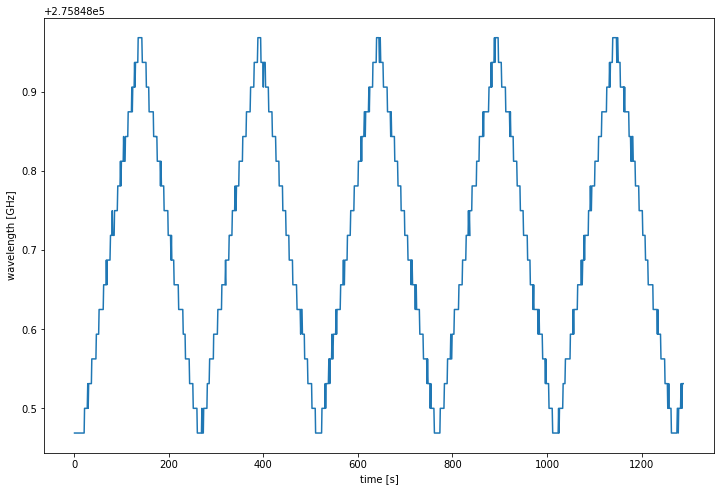

In [6]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(wavemeter[:,0],wavemeter[:,1])
ax.set_xlabel('time [s]')
ax.set_ylabel('wavelength [GHz]');

# Finding unique wavelength values from the wavemeter

In [7]:
def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

230


Text(0.5, 0, 'time [ms]')

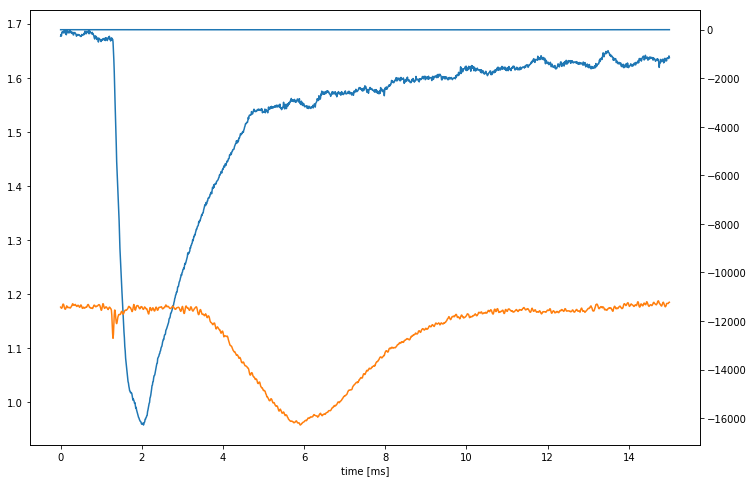

In [544]:
yag_fire = [idx for idx in range(1,len(fast_daq)) if fast_daq['PXIe5171_{0}'.format(idx)][:,5].max() > 300]

rate = 1/2
wavelength_values = []
for idx in yag_fire:
    wavelength_values.append((int(idx), wavemeter[:,1][find_nearest_idx(wavemeter[:,0], idx*rate)]))
wavelength_values = np.array(wavelength_values)    
from scipy.optimize import curve_fit

def gaus(x,a,x0,sigma, b):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))+b

idx = 200
idx = yag_fire[idx]
print(idx)

x = np.linspace(0,1500,1500)/100

data_a = fast_daq['PXIe5171_{0}'.format(idx)][:,1]/fast_daq['PXIe5171_{0}'.format(idx)][:,4]
data_f = fast_daq['PXIe5171_{0}'.format(idx)][:,2]

p0 = (-0.2, 8, 1, -1)
bounds = ([-10,5,0,-2],[0,11,4,-0.5])
try:
    fit, pcov = curve_fit(gaus, x, data_f, p0 = p0, bounds = bounds)
except RuntimeError:
    pass

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(x, data_a)
ax1 = ax.twinx()
ax1.plot(x, data_f, 'C1')
ax1.plot(x, gaus(x, *fit))

ax.set_xlabel("time [ms]")

In [11]:
import tqdm
fits = []
pcovs = []
x = np.linspace(0,1500,1500)/100

for idx in tqdm.tqdm(yag_fire):
    if fast_daq['PXIe5171_{0}'.format(idx)][:,4].min() > 1e3:
        data_f = fast_daq['PXIe5171_{0}'.format(idx)][:,2]/fast_daq['PXIe5171_{0}'.format(idx)][:,4]
        p0 = (-0.2, 6, 1, -1)
        bounds = ([-10,4,0,-2],[0,11,4,-0.5])
        try:
            fit, pcov = curve_fit(gaus, x, data_f, p0 = p0, bounds = bounds)
            fits.append((idx,fit))
        except RuntimeError:
            print(idx)
        pcovs.append((idx,pcov))
fits = dict(fits)

100%|██████████████████████████████████████████████████████████████████████████████| 2549/2549 [00:43<00:00, 59.05it/s]


In [25]:
# def find_nearest_value(set_val, val1, val2):
#     if (np.abs(set_val - val1) > 200) & (np.abs(set_val - val2) > 200):
#         return set_val
#     elif np.abs(set_val-val1) < np.abs(set_val-val2):
#         return val1
#     else:
#         return val2
    
def find_nearest_value(set_val, val1, val2):
    if (np.abs(set_val - val1) > 200) & (np.abs(set_val - val2) > 200):
        return np.nan
    elif np.abs(set_val-val1) < np.abs(set_val-val2):
        return val1
    else:
        return val2

In [26]:
import datetime as dt

scan_name = '2019-2-27_scan1.lvm'

with open(data_loc+scan_name, 'r') as f:
    lines = f.read().split('\n')
    date = lines[9]
    time = lines[10]
    start_time = dt.datetime.strptime(date.split(',')[-1]+' '+time.split(',')[-1][:15], "%Y/%m/%d %H:%M:%S.%f")
    values = lines[23:-1]
    frequencies = []
    nan_counter = 0
    for val in values:
        a,b,c,d = val.split(',')
        if (float(a) == 0) or (float(a) == 1) or (float(a) == 2) or (float(a) == 3):
            continue
        if b == '':
            continue
        b = float(b)
        try:
            c = float(c)
        except ValueError:
            continue
        d = float(d)
        if np.isnan(d):
            d = 1e5
        if (len(frequencies) > 1):
            if (np.abs(frequencies[-1][1]-b) > 900):
                b += 1000
                c += 1000
                d += 1000
        t = (start_time+dt.timedelta(seconds = float(a))).timestamp()-fast_start
        nearest = find_nearest_value(b,c,d)
        
        if np.isnan(nearest):
            nan_counter += 1
            continue
        frequencies.append((t,b,nearest))
    frequencies = np.array(frequencies)
print(nan_counter)

10208


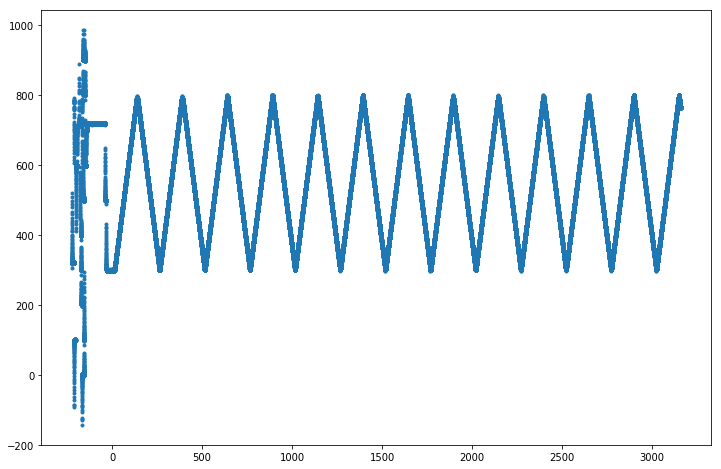

In [27]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(frequencies[:,0], frequencies[:,2],'.')

In [36]:
rate = 1/2
frequency_values = []
for idx in yag_fire:
    frequency_values.append((int(idx), frequencies[:,2][find_nearest_idx(frequencies[:,0], idx*rate-1.5)]))
frequency_values = np.array(frequency_values)

frequency_amp = []
for idx_f in fits:
    if fits[idx_f][0] < 0:
        frequency_amp.append((dict(frequency_values)[idx_f], np.abs(fits[idx_f][0]), idx_f))
frequency_amp = np.array(frequency_amp)
frequency_amp_wavemeter_cal = frequency_amp.copy()
frequency_amp_wavemeter_cal[:,0] += wavelength_values[0,1]*1e3-frequency_amp[0,0]

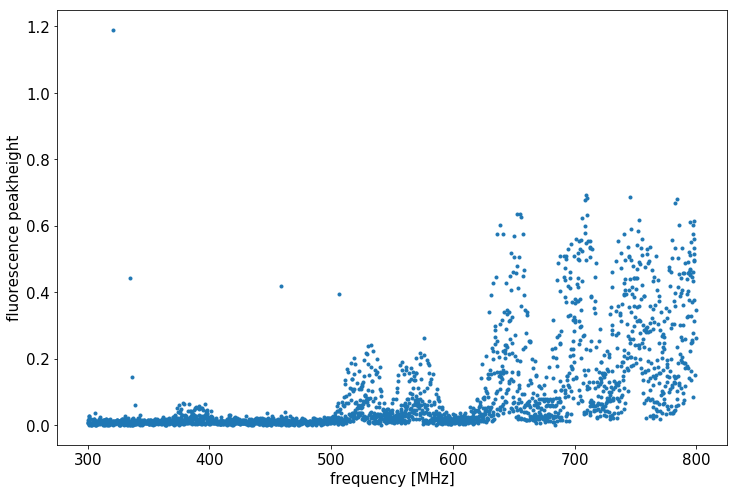

In [35]:
conversion = 1
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(frequency_amp[:,0]*conversion, frequency_amp[:,1], '.')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.set_xlabel('frequency [MHz]', fontsize = 15)
ax.xaxis.get_offset_text().set_size(15)
ax.set_ylabel('fluorescence peakheight', fontsize = 15);

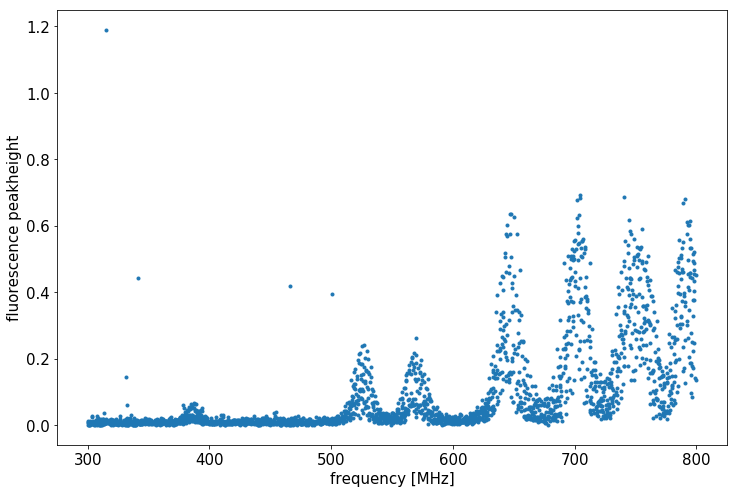

In [37]:
conversion = 1
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(frequency_amp[:,0]*conversion, frequency_amp[:,1], '.')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.set_xlabel('frequency [MHz]', fontsize = 15)
ax.xaxis.get_offset_text().set_size(15)
ax.set_ylabel('fluorescence peakheight', fontsize = 15);

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice.
  


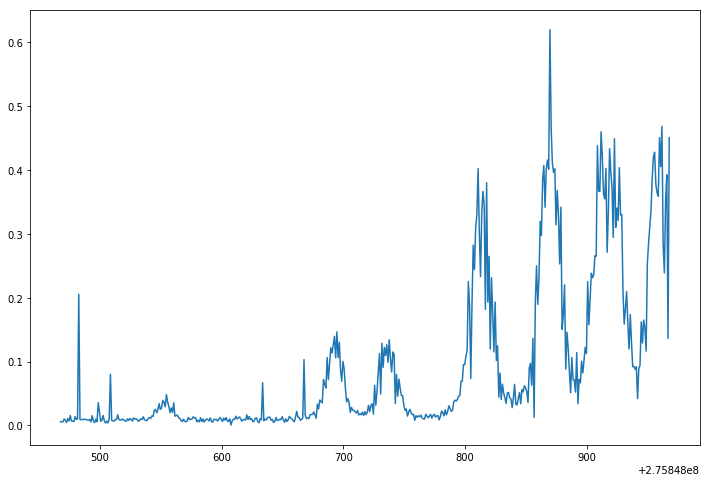

In [43]:
fit_array = frequency_amp_wavemeter_cal[frequency_amp_wavemeter_cal[:,0].argsort()]

df = 1
f_bins = np.arange(fit_array[:,0].min(), fit_array[:,0].max()+df, df)
bin_indices = np.digitize(fit_array[:,0], f_bins)
bin_means = np.array([fit_array[:,1][bin_indices == i].mean() for i in range(1, len(f_bins))])
bin_errors = np.array([fit_array[:,1][bin_indices == i].std() for i in range(1, len(f_bins))])
midpoint = np.diff(f_bins)/2+f_bins[:-1]

mask_nan = ~np.isnan(bin_means)
bin_means = bin_means[mask_nan]
bin_errors = bin_errors[mask_nan]
midpoint = midpoint[mask_nan]

fig, ax = plt.subplots(figsize = (12,8))
# ax.errorbar(midpoint, bin_means, yerr = bin_errors, fmt = '.');
ax.plot(midpoint, bin_means);

# Integrate Peaks

In [313]:
import tqdm
integrals = []
x = np.linspace(0,1500,1500)/100
dx = 1/1e5

for idx in tqdm.tqdm(yag_fire):
    # Check if UV is on
    if fast_daq['PXIe5171_{0}'.format(idx)][:,4].min() > 1e3:
        data_f = fast_daq['PXIe5171_{0}'.format(idx)][:,2]
        background = np.trapz(data_f[:100], dx=dx)
        signal = np.trapz(data_f[200:1100], dx=dx)-9*background
        integrals.append((idx,signal*-1,background*-1))
integrals = np.array(integrals)

100%|███████████████████████████████████████████████████████████████████████████| 2549/2549 [00:00<00:00, 12311.82it/s]


In [314]:
rate = 1/2
frequency_values = []
for idx in yag_fire:
    frequency_values.append((int(idx), frequencies[:,2][find_nearest_idx(frequencies[:,0], idx*rate-1.5)]))
frequency_values = np.array(frequency_values)

frequency_amp = []
for val in integrals:
    idx_int = val[0]
    frequency_amp.append((dict(frequency_values)[idx_int], val[1], idx_int))
frequency_amp = np.array(frequency_amp)
frequency_amp_wavemeter_cal = frequency_amp.copy()
frequency_amp_wavemeter_cal[:,0] += wavelength_values[0,1]*1e3-frequency_amp[0,0]

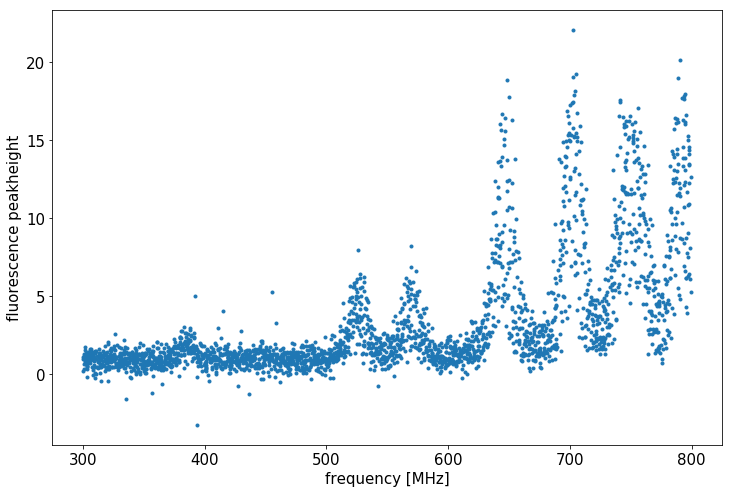

In [315]:
conversion = 1
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(frequency_amp[:,0]*conversion, frequency_amp[:,1], '.')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.set_xlabel('frequency [MHz]', fontsize = 15)
ax.xaxis.get_offset_text().set_size(15)
ax.set_ylabel('fluorescence peakheight', fontsize = 15);

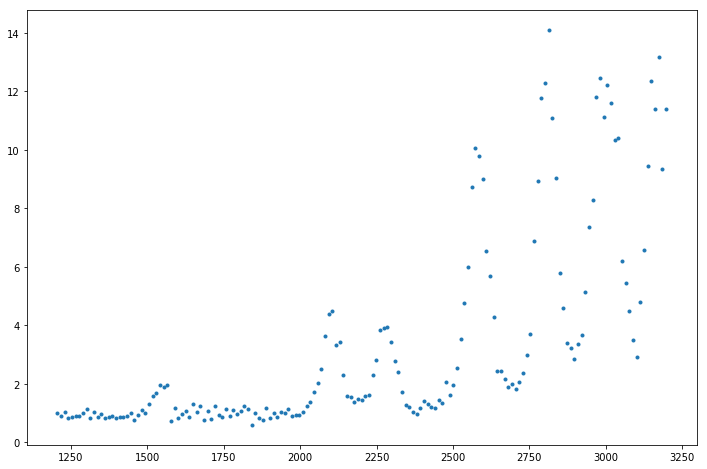

In [535]:
fit_array = frequency_amp[frequency_amp_wavemeter_cal[:,0].argsort()]
fit_array[:,0] *= 4

df = 12
f_bins = np.arange(fit_array[:,0].min(), fit_array[:,0].max()+df, df)
bin_indices = np.digitize(fit_array[:,0], f_bins)
bin_means = np.array([fit_array[:,1][bin_indices == i].mean() for i in range(1, len(f_bins))])
bin_errors = np.array([fit_array[:,1][bin_indices == i].std() for i in range(1, len(f_bins))])
midpoint = np.diff(f_bins)/2+f_bins[:-1]

mask_nan = ~np.isnan(bin_means)
bin_means = bin_means[mask_nan]
bin_errors = bin_errors[mask_nan]
midpoint = midpoint[mask_nan]

fig, ax = plt.subplots(figsize = (12,8))
# ax.errorbar(midpoint, bin_means, yerr = bin_errors, fmt = '.');
ax.plot(midpoint, bin_means, '.');

In [550]:
s = 20
factor = 50
p0 = [(1.0),(s,1550,2*factor),(s,2100,5*factor),(s,2275,5*factor),(s,2575,10*factor),(s,2800,14*factor),(s,2960,13*factor),(s,3025,13*factor)]#,(s,3200,13*factor)]
# p0 = [(0.0001),(s,1550,0.01),(s,2100,0.0006*100),(s,2300,0.0006*100),(s,2600,0.0015*100),(s,2800,0.002*100),(s,2950,0.00175*100),(s,3050,0.00175*100),(s,3200,0.0018*100)]

In [577]:
from lmfit import models
from lmfit import Model
def offset(x,offset):
    return np.ones(len(x))*offset

model_1 = models.VoigtModel(prefix='R0_F0_')
model_2 = models.VoigtModel(prefix='R0_F1_')
model_3 = models.VoigtModel(prefix='Q1_')
model_4 = models.VoigtModel(prefix='Q12_')
model_5 = models.VoigtModel(prefix='Q23_')
model_6 = models.VoigtModel(prefix='Q34_1_')
model_7 = models.VoigtModel(prefix='Q34_2_')
model_8 = models.VoigtModel(prefix='Next_')
model_bg = Model(offset)
model = model_bg+model_1+model_2+model_3+model_4+model_5+model_6+model_7#+model_8

In [578]:
flat_params = []
for sublist in p0:
    if type(sublist) == float:
        flat_params.append(sublist)
    else:
        for item in sublist:
            flat_params.append(item)
pars = {}
for par, key in zip(flat_params, model.param_names):
    pars[key] = par 
params = model.make_params(**pars)
for par in params:
    params[par].set(min=0)
    if 'sigma' in par:
        params[par].set(max = 50)
    elif 'center' in par:
        params[par].set(min = 1400, max = 3500)

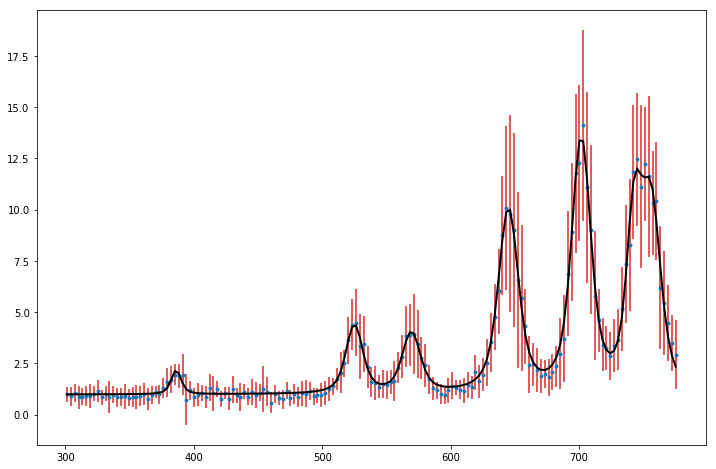

In [651]:
offset = 8
x = midpoint[:-offset]
y = bin_means[:-offset]
err = bin_errors[:-offset]
result = model.fit(y, params, x=x, weights = err)
fig, ax = plt.subplots(figsize = (12,8))
ax.errorbar(x/4,y, yerr = err, fmt = '.', ecolor = 'C3', zorder = -1)
# ax.plot(x, result.init_fit, '--')
ax.plot(x/4, result.best_fit, 'k-', lw = 2)

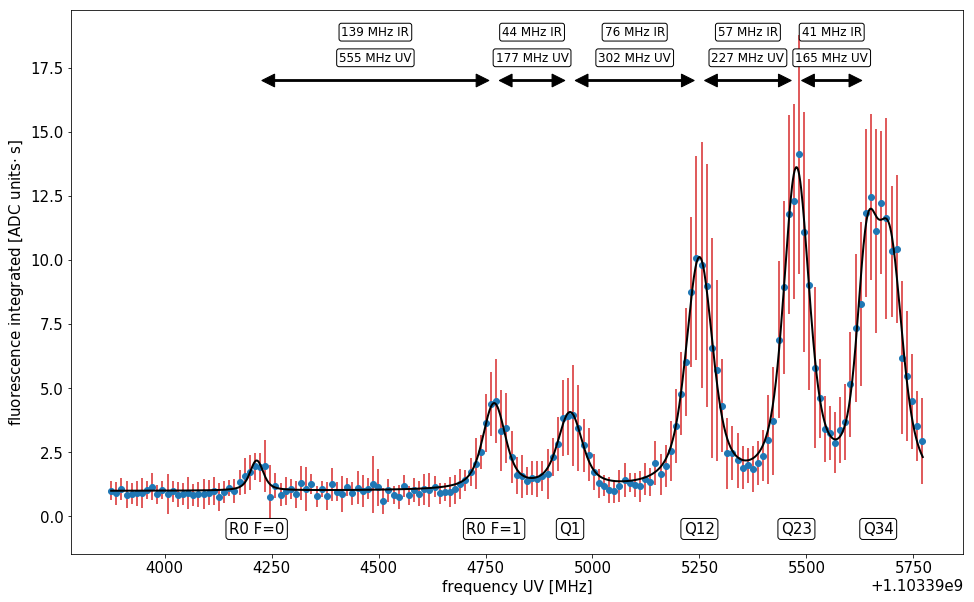

In [622]:
fit_x = np.linspace(x.min(), x.max()+1, 1001)
x_offset = frequency_amp_wavemeter_cal[0,0]*4-x[0]
plocs = []
for par in result.best_values:
    if 'center' in par:
        plocs.append(result.best_values[par])
plocs.sort()

fig, ax = plt.subplots(figsize = (16,10))
ax.errorbar(x+x_offset,y, yerr = err, fmt = '.', ecolor = 'C3', zorder = -1, ms = 12)
ax.plot(fit_x+x_offset, model.eval(result.params, x=fit_x), 'k-', lw = 2)

height_arrow = 17
height_dist = 17.75
height_peakl = -0.5
bbox = dict(boxstyle="round", fc="w", ec="k", pad=0.2)
labels = ["R0 F=0", "R0 F=1", "Q1", "Q12", "Q23", "Q34"]
for ploc, dist, lab in zip(plocs[:-1], np.diff(plocs[:-1]), labels):
    ploc += x_offset
    ax.text((ploc+dist/2),height_dist,'{0:.0f} MHz UV'.format(dist), horizontalalignment='center', fontsize = 12, bbox= bbox)
    ax.text((ploc+dist/2),height_dist+1,'{0:.0f} MHz IR'.format(dist/4), horizontalalignment='center', fontsize = 12, bbox= bbox)
    ax.text((ploc),height_peakl,lab, horizontalalignment='center', verticalalignment = 'center', fontsize = 15, bbox= bbox)

    ax.arrow((ploc+28),height_arrow,(dist-28*2.5),0, shape = 'full', head_width=0.5, head_length=30, fc='k', ec='k', width = .05)
    ax.arrow((ploc+(dist-28)),height_arrow,(-(dist-28*2.5)),0, shape = 'full', head_width=0.5, head_length=30, fc='k', ec='k', width = .05)

ax.text((np.mean(plocs[-2:])+x_offset),height_peakl,labels[-1], horizontalalignment='center', verticalalignment = 'center', fontsize = 15, bbox= bbox)
    
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.set_xlabel('frequency UV [MHz]', fontsize = 15)
ax.xaxis.get_offset_text().set_size(15)
ax.set_ylabel('fluorescence integrated [ADC units$\cdot$ s]', fontsize = 15);
fig.savefig('scanning_UV_R0toQ34.png')

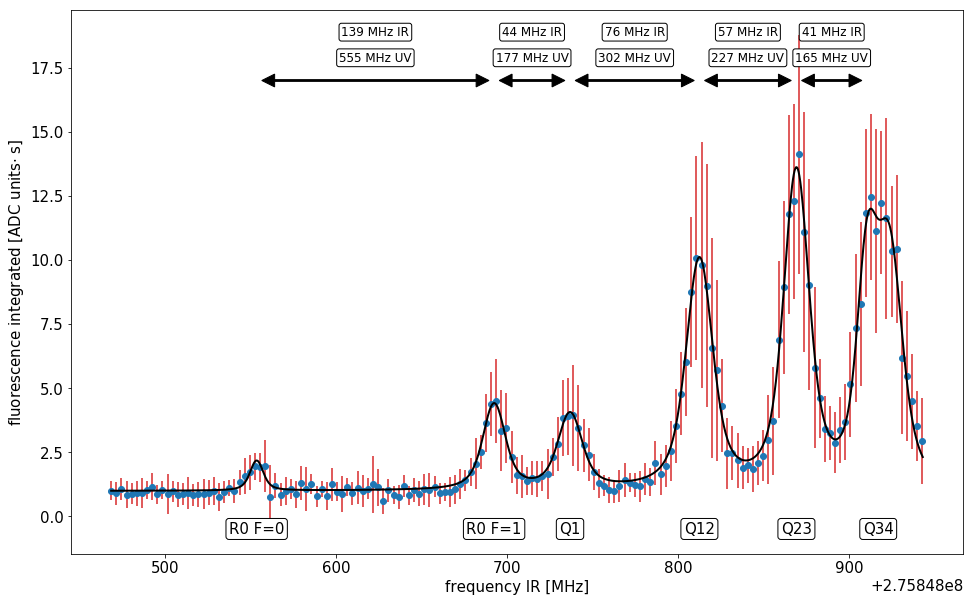

In [621]:
fit_x = np.linspace(x.min(), x.max()+1, 1001)
x_offset = frequency_amp_wavemeter_cal[0,0]*4-x[0]
plocs = []
for par in result.best_values:
    if 'center' in par:
        plocs.append(result.best_values[par])
plocs.sort()

fig, ax = plt.subplots(figsize = (16,10))
ax.errorbar((x+x_offset)/4,y, yerr = err, fmt = '.', ecolor = 'C3', zorder = -1, ms = 12)
ax.plot((fit_x+x_offset)/4, model.eval(result.params, x=fit_x), 'k-', lw = 2)

height_arrow = 17
height_dist = 17.75
height_peakl = -0.5
bbox = dict(boxstyle="round", fc="w", ec="k", pad=0.2)
labels = ["R0 F=0", "R0 F=1", "Q1", "Q12", "Q23", "Q34"]
for ploc, dist, lab in zip(plocs[:-1], np.diff(plocs[:-1]), labels):
    ploc += x_offset
    ploc /= 4
    dist /= 4
    ax.text((ploc+dist/2),height_dist,'{0:.0f} MHz UV'.format(dist*4), horizontalalignment='center', fontsize = 12, bbox= bbox)
    ax.text((ploc+dist/2),height_dist+1,'{0:.0f} MHz IR'.format(dist), horizontalalignment='center', fontsize = 12, bbox= bbox)
    ax.text((ploc),height_peakl,lab, horizontalalignment='center', verticalalignment = 'center', fontsize = 15, bbox= bbox)

    ax.arrow((ploc+28/4),height_arrow,(dist-28*2.5/4),0, shape = 'full', head_width=0.5, head_length=30/4, fc='k', ec='k', width = 0.05)
    ax.arrow((ploc+(dist-28/4)),height_arrow,(-(dist-28*2.5/4)),0, shape = 'full', head_width=0.5, head_length=30/4, fc='k', ec='k', width = .05)

ax.text((np.mean(plocs[-2:])+x_offset)/4,height_peakl,labels[-1], horizontalalignment='center', verticalalignment = 'center', fontsize = 15, bbox= bbox)
    
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.set_xlabel('frequency IR [MHz]', fontsize = 15)
ax.xaxis.get_offset_text().set_size(15)
ax.set_ylabel('fluorescence integrated [ADC units$\cdot$ s]', fontsize = 15);
fig.savefig('scanning_IR_R0toQ34.png')

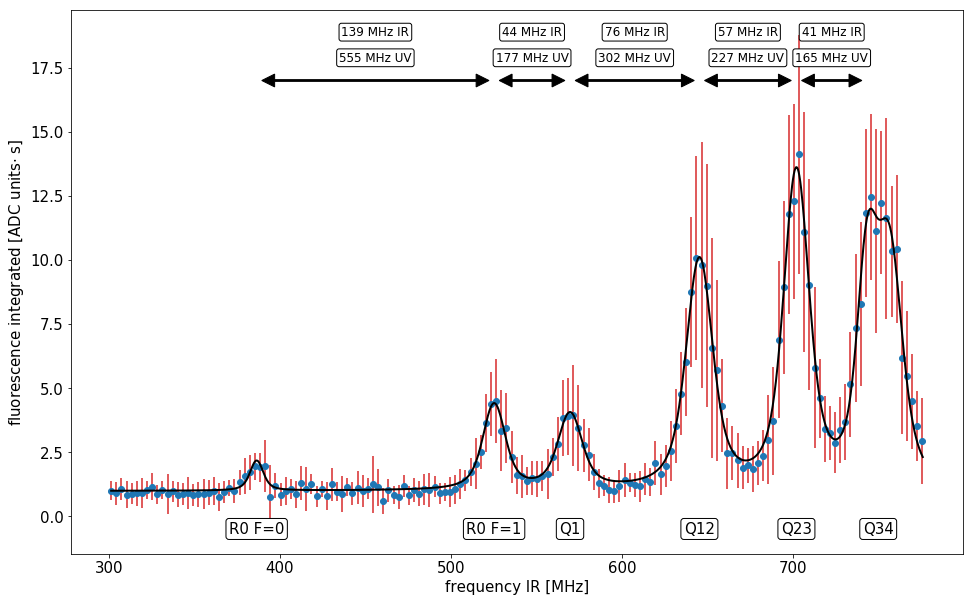

In [623]:
fit_x = np.linspace(x.min(), x.max()+1, 1001)
x_offset = 0
plocs = []
for par in result.best_values:
    if 'center' in par:
        plocs.append(result.best_values[par])
plocs.sort()

fig, ax = plt.subplots(figsize = (16,10))
ax.errorbar((x+x_offset)/4,y, yerr = err, fmt = '.', ecolor = 'C3', zorder = -1, ms = 12)
ax.plot((fit_x+x_offset)/4, model.eval(result.params, x=fit_x), 'k-', lw = 2)

height_arrow = 17
height_dist = 17.75
height_peakl = -0.5
bbox = dict(boxstyle="round", fc="w", ec="k", pad=0.2)
labels = ["R0 F=0", "R0 F=1", "Q1", "Q12", "Q23", "Q34"]
for ploc, dist, lab in zip(plocs[:-1], np.diff(plocs[:-1]), labels):
    ploc += x_offset
    ploc /= 4
    dist /= 4
    ax.text((ploc+dist/2),height_dist,'{0:.0f} MHz UV'.format(dist*4), horizontalalignment='center', fontsize = 12, bbox= bbox)
    ax.text((ploc+dist/2),height_dist+1,'{0:.0f} MHz IR'.format(dist), horizontalalignment='center', fontsize = 12, bbox= bbox)
    ax.text((ploc),height_peakl,lab, horizontalalignment='center', verticalalignment = 'center', fontsize = 15, bbox= bbox)

    ax.arrow((ploc+28/4),height_arrow,(dist-28*2.5/4),0, shape = 'full', head_width=0.5, head_length=30/4, fc='k', ec='k', width = 0.05)
    ax.arrow((ploc+(dist-28/4)),height_arrow,(-(dist-28*2.5/4)),0, shape = 'full', head_width=0.5, head_length=30/4, fc='k', ec='k', width = .05)

ax.text((np.mean(plocs[-2:])+x_offset)/4,height_peakl,labels[-1], horizontalalignment='center', verticalalignment = 'center', fontsize = 15, bbox= bbox)
    
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.set_xlabel('frequency IR [MHz]', fontsize = 15)
ax.xaxis.get_offset_text().set_size(15)
ax.set_ylabel('fluorescence integrated [ADC units$\cdot$ s]', fontsize = 15);

In [634]:
(np.array(plocs)+frequency_amp_wavemeter_cal[0,0]*4-x[0])[4]/4/1e3

275848.86915588024

In [639]:
(plocs[4]/4+frequency_amp_wavemeter_cal[0,0]-x[0]/4)/1e3

275848.86915588024